In [2]:
tutorial_path = "./"
dependencies = f'{tutorial_path}dependencies/'

<a id="0"></a>

# 📚 Tutorial - Rhythmic Structure

> **Topics:**
> 1. [Introducing Rhythmic Structure](#1)
> 2. [Accessing Rhythm](#2)
> 3. [Casting Numbers as music21 Scores (Short)](#3)

> **By the end of the session you will:**
> - ✅ Extract rhythm metrics from xml files using music21
> - ✅ Translate sequences of numbers into musical scores using music21
> - ✅ Instantiate and perform operations with a new type of rhythmic object in Python


<a id="1"></a>

***---***

## 1. Introducing Rhythmic Structure
###### [back to top](#0)

***---***

#### 🔵 What?

A pared down explanation of rhythm might emphasize:
- **duration**: the amount of time a musical event (note, chord, rest) or group of musical events lasts
- **onset**: the location in a score or measure at which an event begins, typically measured in terms of beat number
- **rest**: the location and balance of moments which do not stimulate the listener (especially in contrast with those that do)

The importance of these elements for rhythmic *structure* arises in how they reinforce or disrupt **meter**, or the recurring pattern of musical event timings that drives a musical piece. Meter is specified in part by the time signature, which informs the number of beats per measure, and in part by onsets, durations, and rests, which implicitly assign importance to certain beats on the **metrical grid**:


![metrical_grid](https://drive.google.com/uc?export=view&id=18iGMM9nleNfxG48PixLlLtP0Qa84JzH-)


In short: rhythmic structure is the scaffolding that defines how often and for how long the listener can expect to hear sounds.

#### 🟡 How?

From the symbolic perspective, composers select the sounded and unsounded durations they desire for their music:   


![notes_rests](https://drive.google.com/uc?export=view&id=1pYjeytLogXmT9oh6SN7LAH_EpwWAOd_-)


The standard unit of measurement in rhythmic analysis is the <u>beat</u> or, equivalently, the unpitched note corresponding to one beat in the active time signature (eg in the chart above, which lists a 4/4 time signature in the final column header, the durational unit could be the quarter note).

Apart from duration, onset, and rest, there are further symbolic aspects (possibly syncopation) and elements of musical performance (rubato) which, though beyond the scope of this introductory notebook, feed into rhythmic structure. All of these intentional rhythmic elements ultimately interact with the listener to bring life to structure.

#### 🟣 Why?

We claim rhthmic elements *interact* with the listener because **rhythm exists in the mind.** When we listen to music, we unconsciously learn the timing pattern characteristic to a piece and begin to anticipate musical events based on this learned pattern. This point is not to be missed: to listen to music is to encode all time-based events into a structure that allows us to form expectations. *This* is where rhythmic structure really exists.

The great benefit of this process is that musicians can rely it to shape an experience. As listeners come to expect a certain pattern, continued reinforcement feels earned and satisfying while deviations can surprise, delight, or worry. Dance becomes possible. Emotions can be inspired. Stories can be told. What we have is a way to start pulling levers with respect to unconscious human behaviour.

<div style="padding:8px 0 8px 15px;border-left:3px solid orange;background-color:#F3F3F3;">
    <h3>Structure of today's exercise</h3>
In this exercise session, we will introduce computational tools for studying, generating, and comparing rhythms. We will define rhythm, access its symbolic aspects in music21, create onset distribution plots in pursuit of metrical grids, train Markov Chain transition tables for use in sequential generation, apply a set of rhythm grammar rules in hierarchical generation, and implement both feature-based and transformation-based rhythm comparison pipelines.

Your task is to fill in missing pieces of code when asked. For each one, you will be given a 🎯 `Goal` guidance that explains the steps you need to implement and a 💻 `API` reference with the steps, functions, or classes you can use to achieve each goal.

#### Setup
All the Python packages you need to install are listed in the next block. This tutorial also assumes you have MuseScore or Finale Notepad installed.

#### Data
All data is included in the dependencies folder.

The Section 2 blue bossa sheet music is available on [MuseScore](https://musescore.com/will_rowsell/blue-bossa-piano)   
The Sections 2-3 Mozart piano sonata note transcriptions are from a DCML corpus on [GitHub](https://github.com/DCMLab/mozart_piano_sonatas/tree/main/MS3)   


</div>

#### 1.1 Get set up

Create and activate a virtual environment to install the packages in the following cell.

In [1]:
!pip install numpy pandas pickle seaborn music21 iteration_utilities
!pip install git+https://github.com/quadrismegistus/prosodic.git
!apt install musescore3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle
  Cloning https://github.com/quadrismegistus/prosodic.git to /tmp/pip-req-build-ycpe8ylc
  Running command git clone --filter=blob:none --quiet https://github.com/quadrismegistus/prosodic.git /tmp/pip-req-build-ycpe8ylc
  Resolved https://github.com/quadrismegistus/prosodic.git to commit d8944c49428bb884227847e3f159cdbaed7f35eb
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/dmort27/syllabiphon to /tmp/pip-install-8xteosqe/syllabiphon_8262bd87e61e49dea046a8efbd0ed729
  Running command git clone --filter=blob:none --quiet https://github.com/dmort27/syllabiphon /tmp/pip-install-8xteosqe/syllabiphon_8262bd87e61e49dea046a8efbd0ed729
  Resolved https://github.com/dmort27/syllabiphon to commit

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import os
import seaborn as sns
import pickle
import music21

from fractions import Fraction
from collections import defaultdict, Counter
from iteration_utilities import deepflatten #flatten nested lists

from music21 import midi, note, stream, instrument, meter, key
import itertools
import random

import string

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id="2"></a>

***---***


## 2. Accessing Rhythm

***---***

Let's move into computational analysis of rhythm. First, let's directly access the elements described above (duration, onset, rest) via music21.

#### 2.1 Pull in the sample score

First, pull in our first sample score and have a listen.

Appreciate the original version while you can! We're about to take a sledgehammer to it in preparation for rhythm analysis. ⚒️

In [21]:
os.listdir()

['dependencies', 'rhythm_tutorial_1.ipynb', 'wow', 'wow.midi']

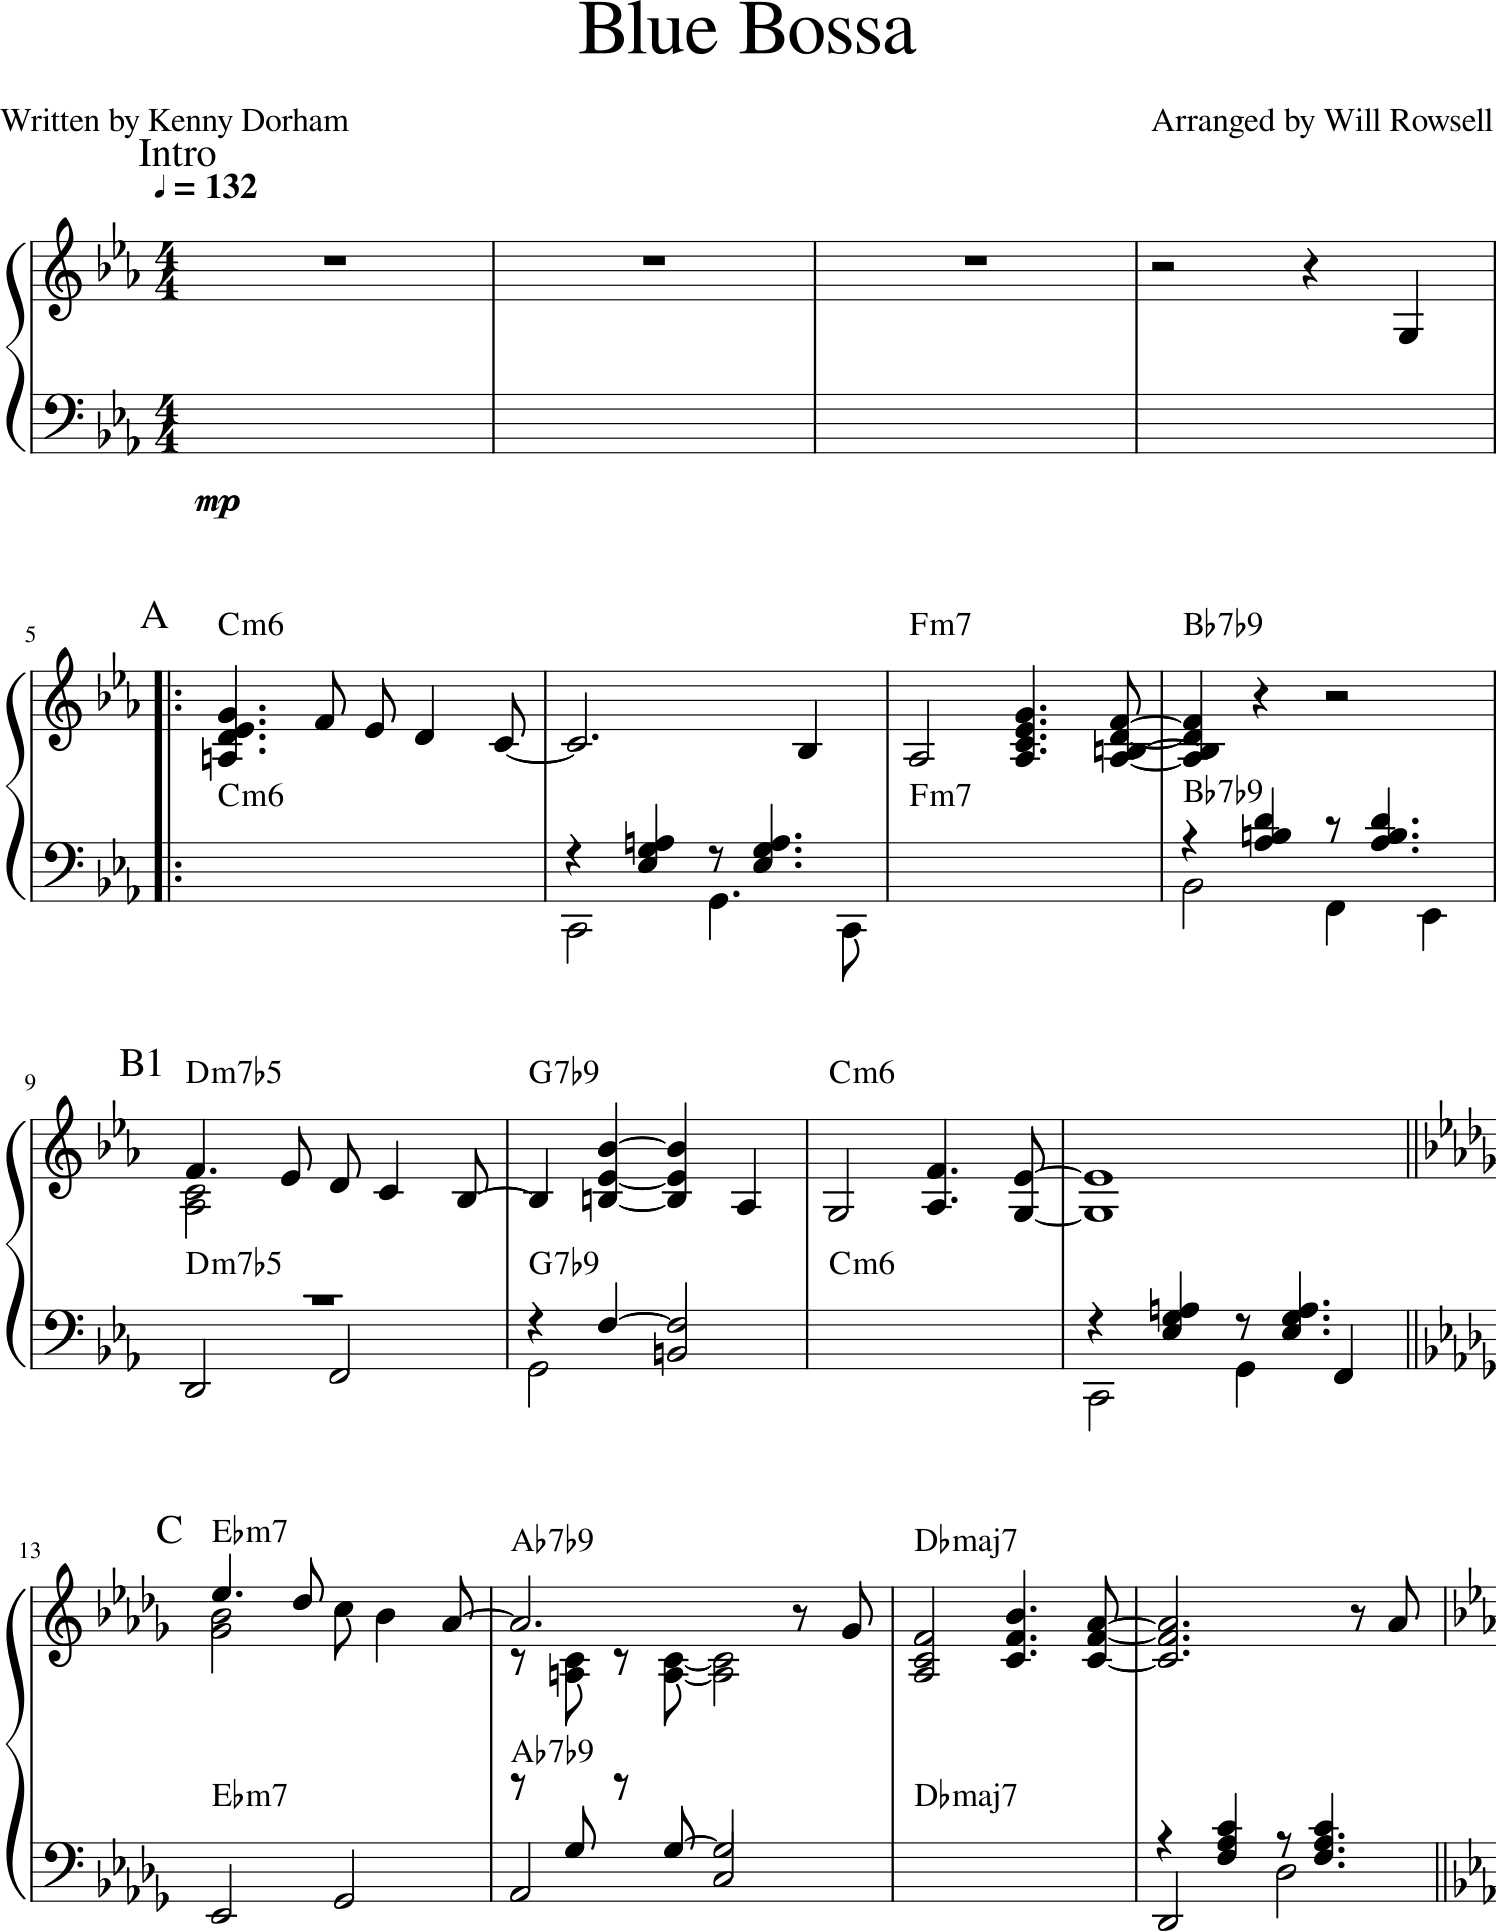

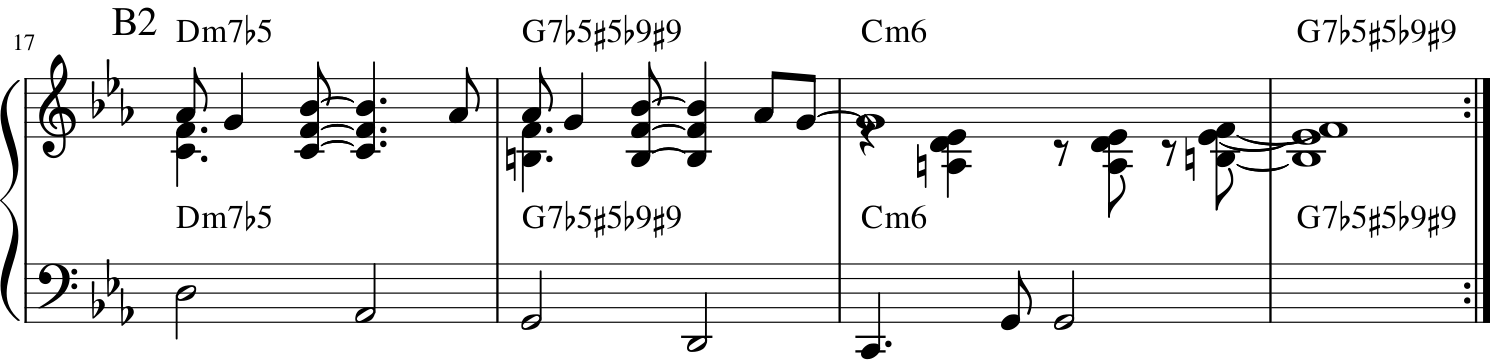

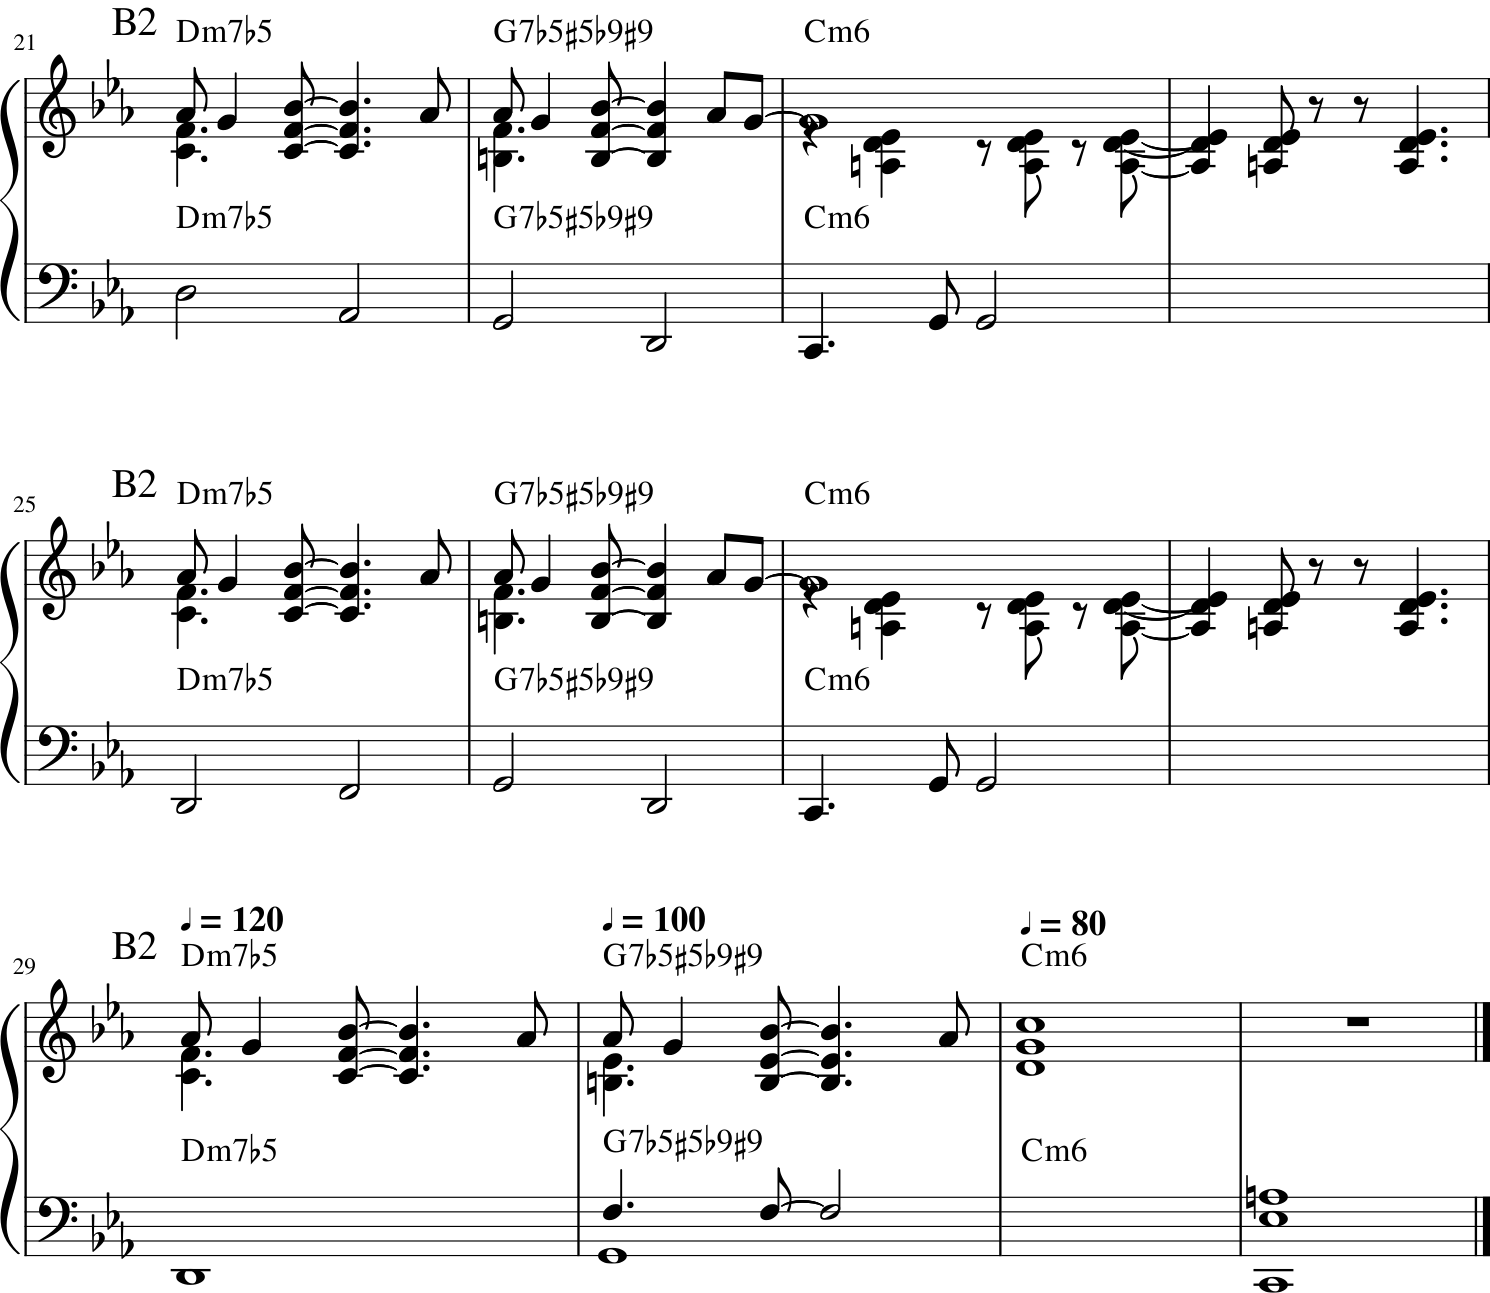

PosixPath('/mnt/c/Users/benkr/Documents/uni/24FS/musicology/digital_musicology_homework_1/ex1/wow.mxl')

In [23]:
import music21
import os
import pandas as pd

# Pull in the score and listen to it a bit
sample_score_tmp = music21.converter.parse(f'{dependencies}blue_bossa.mxl')
sample_score_tmp.show()
sample_score_tmp.write('mxl', 'wow.mxl')

A groovy (and famous) little tune. But we don't need all that groove! The next cell uses a function in helpers.py to strip away all the things we really don't need to study rhythm. As with all functions from helpers.py, you are encouraged but not required to take a look at the underlying code, which may be a good reference for your own work in the future.

In [ ]:
# helper functions

def helpers_simplify_score_for_rhythm_analysis(sample_score_tmp):

    # remove chord charts, metronome mark, dynamics
    for part in sample_score_tmp.parts:
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.harmony.ChordSymbol):
                    measure.remove(event)
                if isinstance(event, music21.tempo.MetronomeMark):
                    measure.remove(event)
                if isinstance(event, music21.dynamics.Dynamic):
                    measure.remove(event)
                if isinstance(event, music21.key.KeySignature):
                    measure.remove(event)

    # combine voice tracks intra-staff (done by extracted staffs and recombining)
    chordified_treble = sample_score_tmp.parts[0].chordify()
    chordified_bass = sample_score_tmp.parts[1].chordify()
    sample_score = music21.stream.Score()
    sample_score.insert(0, chordified_treble)
    sample_score.insert(0, chordified_bass)

    # cast all single-note chord objects (created by chordify) as note objects so students see more typical music21 score object structure
    staff_count = 0
    for part in sample_score.parts:
        staff_count += 1
        for measure in part.getElementsByClass('Measure'):
            for event in measure:
                if isinstance(event, music21.chord.Chord): # and len(event.notes) == 1:
                    note_version = music21.note.Note()
                    if staff_count == 1:
                        note_version.pitch = music21.pitch.Pitch('C4')
                    elif staff_count == 2:
                        note_version.pitch = music21.pitch.Pitch('C3')
                    note_version.duration = event.duration
                    start_found = 0
                    continue_found = 0
                    none_found = 0
                    all_ties_stop = 1
                    for nte in event.notes:
                        try:
                            curr_tie_obj = nte.tie.type
                        except:
                            curr_tie_obj = None
                        if (curr_tie_obj == 'start'):
                            start_found = 1
                        if (curr_tie_obj == 'continue'):
                            continue_found = 1
                        if (curr_tie_obj is None):
                            none_found = 1
                        if (curr_tie_obj != 'stop'):
                            all_ties_stop = 0
                    if start_found == 1:
                        note_version.tie = music21.tie.Tie('start')
                    elif none_found == 1:
                        note_version.tie = None
                    elif all_ties_stop == 1:
                        note_version.tie = music21.tie.Tie('stop')
                    elif continue_found == 1:
                        note_version.tie = music21.tie.Tie('continue')
                    note_version.offset = event.offset
                    note_version.articulations = event.articulations
                    note_version.expressions = event.expressions
                    measure.replace(event, note_version)

    # fix instances where tie start leads to tie None (should be no tie but previous loop isn't built to observe two consecutive elements)
    # the ties are a pain >:"{
    for part in sample_score.parts:
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)-1):
                curr_event = measure[i]
                next_event = measure[i+1]
                if isinstance(curr_event, music21.note.Note) and isinstance(next_event, music21.note.Note):
                    try:
                        curr_tie = curr_event.tie.type
                    except:
                        curr_tie = None
                    try:
                        next_tie = next_event.tie.type
                    except:
                        next_tie = None
                    if (curr_tie == 'start' or curr_tie == 'continue') and (next_tie == 'start' or next_tie is None):
                        measure[i].tie = music21.tie.Tie('stop')
                if isinstance(curr_event, music21.note.Rest):
                    measure[i].tie = None

    # combine tied notes intra-staff
    for part in sample_score.parts:
        active_tie = 0
        for measure in part.getElementsByClass('Measure'):
            for i in range(len(measure)):
                if isinstance(measure[i], music21.note.Note):
                    if measure[i].tie is not None:
                        if measure[i].tie.type == "start":
                            active_tie = 1
                        elif measure[i].tie.type == "stop" and active_tie == 1:
                            active_tie = 0
                        elif measure[i].tie.type == "stop" and active_tie == 0:
                            measure[i].tie = None

    treble = sample_score.parts[0]
    for measure in treble.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    bass = sample_score.parts[1]
    for measure in bass.getElementsByClass('Measure'):
        i = 0
        len_measure = len(measure)
        while i < len_measure-1:
            if isinstance(measure[i], music21.note.Note) and isinstance(measure[i+1], music21.note.Note):
                if measure[i].tie is not None and measure[i+1].tie is not None:
                    measure[i].duration = music21.duration.Duration(measure[i].duration.quarterLength + measure[i+1].duration.quarterLength)
                    if measure[i+1].tie is not None:
                        if measure[i+1].tie.type == "stop":
                            measure[i].tie = None
                    measure.remove(measure[i+1])
            i += 1
            len_measure = len(measure)

    sample_score = music21.stream.Score()
    sample_score.insert(0, treble)
    sample_score.insert(0, bass)

    # deciding against repeat expands for now due to issues with measure number

    return sample_score


In [ ]:
import sys
sys.path.append("dependencies")

# Strip out unnecessary elements
sample_score = helpers_simplify_score_for_rhythm_analysis(sample_score_tmp)
sample_score.show()


Key signature, chord vs. note, separate voice tracks intra-staff, chord charts, dynamics, **pitch** - these are all <u>irrelevant</u>! It may not be as exciting to listen to (see for yourself), but it should be easier to deal with visually and in music21.

Let's print out the rhythm elements described in the theory above for the first two measures of our sample score. The loop below may be offputting, but make sure you understand it. It's showing you how to access event-level information from a score.

In [ ]:
import music21
print("Data rows will be of the form:\n<type> <onset_in_measure> <duration> <tie> \n")
print("Time Signature: " + sample_score.flat.getElementsByClass('TimeSignature')[0].ratioString + "\n")

for staff in sample_score.parts:
    staff_name = staff.elements[1].clef.name
    for measure in staff.getElementsByClass('Measure'):
        if measure.measureNumber <= 2 and measure.measureNumber > 0:
            print(staff_name + " measure " + str(measure.measureNumber))
            for event in measure.recurse():
                label = ""
                if isinstance(event, music21.note.Note):
                    label = "sounded"
                if isinstance(event, music21.note.Rest):
                    label = "unsounded"
                try:
                    tie_info = "tie_" + event.tie.type
                except:
                    tie_info = ""
                if label != "":
                    print(label, event.offset, event.duration.quarterLength, tie_info)
    print("")

![bossa_m1m2](https://drive.google.com/uc?export=view&id=1d1gTs6QYCXHLwccPBl8VFmoKK0M4YGoH)


To address the rows:
- 'Sounded' or 'unsounded' is self explanatory
- The second datapoint in each row refers to **onset**: the (0-indexed) beat at which the note or rest begins. Hence, 3.5 means an event begins halfway through the *fourth* (and final) beat.
- The third datapoint in each row corresponds to **duration**, and is measured in quarter notes via music21's quarterLength attribute. In this case, this number equivalently refers to number of beats - but **only** because the time signature has a 4 at the bottom. **quarterLength will not always refer to beat count!**
- Tie information is occasionally a fourth datapoint. That a note <u>shares an onset</u> with a previous note is relevant to rhythm analysis.

Time for *you* to get involved. Would you please throw the data above (+ a bit more) into a dataframe? It'd be very kind of you.

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Cast the rhythm data in the sample score as a pandas dataframe. The dataframe should have one note or rest per row, with the following columns:
  
  - *staff*: "treble" or "bass"
  - *measure_number*: 1, 2, 3, ...
  - *event_type*: "sounded" or "unsounded"
  - *onset_in_measure* (float): [0,4)
  - ***onset_in_score*** (float): [0, ∞)
  - *duration* (float): (0,4]
  - *tie_info* (string): "tie_start", "tie_continue", "tie_stop", or nothing

  Please do not 'unfold' repeat bars. This tutorial was designed without such unfolding. For your own reference, music21 has a method called expandRepeats() that can help with this.<br>

- 💻  **API:**  The code above extracts everything you need except *onset_in_score*. You need to (1) create *onset_in_score* and (2) actually place the data into a pandas dataframe.

  - *onset_in_score* can be a simple multiplication composed of measure number and *onset_in_measure*
  - There are many ways to create a pandas dataframe. One method would be to maintain a list of 7-element tuples and later convert the list with proper column names.

  Hint: start with the code above.

</div>

In [ ]:
import pandas as pd

## STUDENT SECTION - ##
rhythm_data_list = []
for clef in sample_score.parts:
    global_onset = 0
    clef_name = clef.elements[1].clef.name
    for measure in clef.getElementsByClass('Measure'):
        for event in measure.recurse():
            label = ""
            if isinstance(event, music21.note.Note):
                label = "sounded"
            if isinstance(event, music21.note.Rest):
                label = "unsounded"
            try:
                tie_info = "tie_" + event.tie.type
            except:
                tie_info = ""
            if label != "":
                global_onset = ((measure.measureNumber-1) * 4) + event.offset
                rhythm_data_list.append((clef_name, measure.measureNumber, label, event.offset, global_onset, event.duration.quarterLength, tie_info))
rhythm_data_df = pd.DataFrame(rhythm_data_list, columns=['staff', 'measure_number', 'event_type', 'onset_in_measure', 'onset_in_score', 'duration', 'tie_info'])
## END STUDENT SECTION ##

# Check output with reference photo
pd.concat([rhythm_data_df.head(11), rhythm_data_df.tail(4)], axis = 0)



![bossa_data](https://drive.google.com/uc?export=view&id=1y85E7GnNF7Mu6K6tSVWwWnAw7pDsL2q2)



Great! Now we have access to rhythm-informing datapoints in a nice clean data structure.

But.. how do we get a handle on what's really happening with our rhythm?

#### 2.2 Distribution of Sounded Event Onsets, 4-Beat Range

If we're curious about the metrical grid specifically, one option is to study the onset locations of sounded events in our score. Let's do this now.

We'll start with the intra-measure onset distribution of sounded events **along the bass staff only**.

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Complete *extract_onset_in_measure()*, which returns a pandas series or Python list containing *onset_in_measure* values for all <u>**bass-staff sounded events**</u>

- 💻  **API:** Filter the *subset* dataframe below for sounded events and extract their *onset_in_measure* values.
    - Be sure to remove notes that are tied to previous notes! We're interested in onsets here, so a note tied to a previous note has already 'started' its sound, so to speak.

</div>

In [ ]:
# helper functions
import matplotlib.pyplot as plt

def helpers_onset_dist(onsets, measure_count = 4):

    if type(onsets) is not list:
        onsets = onsets.tolist()

    beat_locations = [i * 0.5 for i in range(10 * measure_count + 1)]
    beat_frequencies = []
    for loc in beat_locations:
        beat_frequencies.append((onsets.count(loc) / len(onsets)))

    fig, ax = plt.subplots()
    ax.plot(beat_locations, beat_frequencies, color='blue')
    if measure_count == 4:
        ax.set_xlabel('Onset in Measure')
    if measure_count == 8:
        ax.set_xlabel('Onset in Two-Measure Sequence')
        ax.axvline(4, linestyle = '--')
    ax.set_ylabel('')
    ax.set_title('Relative Frequency of Onset Locations')
    ax.set_xlim(0, measure_count)
    ax.set_ylim(0, .5)


In [ ]:
subset = rhythm_data_df[rhythm_data_df['staff'] == 'bass']

def extract_onset_in_measure(subset):
    ## STUDENT SECTION -  ##
    return subset[(subset['event_type'] == "sounded") & (subset['tie_info'] != "tie_stop")]['onset_in_measure']
    ## END STUDENT SECTION ##

onsets_bass = extract_onset_in_measure(subset)
helpers_onset_dist(onsets_bass, 4) # graphing function

There are two clear maxima at the first and third beats in the measure (recall 0-indexing). Apart from the increase ahead of beat 3, sounded events infrequently occur at other onset locations.

If we wanted to draw a metrical grid for this score's **bass clef only**, and we restricted ourselves to drawing beat emphasis circles only on the beat level (as opposed to the sub-beat level), the graph above recommends the grid below.



![bossa_grid_bass](https://drive.google.com/uc?export=view&id=1YNVB0fWGSZ2FJPOZElqaTBd0csBIiRCC)



As you can see, the score also visually recommends this austere, intuitive rhythmic pattern. But does this grid make sense to your ear? Have a listen to the bass staff alone with the next block. Clap along to the beat. Ensure you make it past the first four measures 😊

In [ ]:
sample_score.parts[1].show()

Sounds reasonable! The first and third beats consistently accompany bass measures in the piece, so much so that occasional ornamentation doesn't disrupt our mental encoding of the metrical system depicted above.

Let's isolate the treble staff to perform the same analysis.

In [ ]:
subset = rhythm_data_df[rhythm_data_df['staff'] == 'treble']
onsets_treble = extract_onset_in_measure(subset)
helpers_onset_dist(onsets_treble, 4)

Hmm... it doesn't appear to be as simple. Once again, beat 1 has a high share in the distribution. But the local peak at beat 3 has been 'pulled forward' to beat 2.5, and the global maximum occurs halfway into the final beat. This is strange.

#### 2.3 Distribution of Sounded Event Onsets, 8-Beat Range

Something we haven't accounted for yet is the possibility that the rhythmic structure is operating at a timescale longer than one measure. Go ahead and pass in onsets not as intra-measure onsets but intra-measure-pair onsets (that is, onsets relative to an 8-beat range rather than 4-beat range).

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Complete *extract_onset_in_measure_pair()*, which returns a pandas series or list containing onset values for all <u>**treble-staff sounded events**</u>. Unlike before, these onset values should range between 0 and 7.5; that is, our new timescale is 8 beats rather than 4.

- 💻  **API:** Filter the *subset* dataframe below for sounded events, extract their *onset_in_score* values, and perform a modulus operation on the extracted values. Once again, remove events tied to previous events.

</div>

In [ ]:
subset = rhythm_data_df[rhythm_data_df['staff'] == 'treble']

def extract_onset_in_measure_pair(subset):
    ## STUDENT SECTION -  ##
    return subset[(subset['event_type'] == "sounded") & (subset['tie_info'] != "tie_stop")]['onset_in_score']%8
    ## END STUDENT SECTION ##

onsets_8beats = extract_onset_in_measure_pair(subset)
helpers_onset_dist(onsets_8beats, 8)

There appears to be quite a weird distortion occurring at the turn of the measure. Let's overlay the two measure-length beat sequences to better visualize.

Notice that our 8-beat sequence can equivalently be thought of as a view of the onset distribution for odd (beats 1-4) and even (beats 5 - 8) measures.

In [ ]:
# helper function

def helpers_onset_dist_overlap_measure_pair(onsets):

    if type(onsets) is not list:
        onsets = onsets.tolist()

    beat_locations = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]

    m1_onsets = [o for o in onsets if o < 4]
    m2_onsets = [o-4 for o in onsets if o >= 4]

    m1_frequencies = []
    m2_frequencies = []
    for loc in beat_locations:
        m1_frequencies.append((m1_onsets.count(loc) / len(onsets)))
        m2_frequencies.append((m2_onsets.count(loc) / len(onsets)))

    fig, ax = plt.subplots()
    ax.plot(beat_locations, m1_frequencies, color='blue')
    ax.plot(beat_locations, m2_frequencies, color='red')
    ax.set_xlabel('Onset in Measure')
    ax.set_ylabel('')
    ax.set_title('Relative Frequency of Onset Locations')
    ax.set_xlim(0, 4)
    ax.set_ylim(0, .5)
    ax.legend(["Odd Measure", "Even Measure"])


In [ ]:
import sys
sys.path.append("dependencies")

helpers_onset_dist_overlap_measure_pair(onsets_8beats)

Two of the most striking disparities occur at the turn of the measure (that is, both the beginning of end of the four beats above). Odd-numbered measures outpace even-numbered measure onsets at the start of the initial beat and end of the final beat. Curiously, odd-numbered measures lack onsets at the beginning of beat four but still have a marked share at the final half beat. Even-numbered measures, meanwhile, show quite a steady distribution of onset locations - except on beat 3, where they have none (once again: don't forget 0-indexing!). Even-numbered measures also conspicuously lack an outsized share of onsets at the first beat.

What exactly is going on? Far and away the most important dynamic at play is the 'pulling forward' of notes from beat 5 (the start of even measures) to halfway through beat 4 (the end of odd measures). This is what's occurring in the red circles below, where ties pull the onset for sounded events forward, de-emphasizing in the even measures what would typically be the strongest beat. The green and blue circles, meanwhile, demonstrate the greater variety seen at the end of even measures relative to odd measures, which is responsible for the steady final-beat distribution among even measures.

Beneath the eight pictured measures you will find a metrical grid **that is based on the onset distributions above**. Here, we allow sub-beat onsets, creating a more granular grid.

![bossa_grid](https://drive.google.com/uc?export=view&id=11gECaHkXpzVbRJ8uE4a0nfwW7VI4F6ce)

Does the metrical grid make sense to your ear? Have a listen below.


Clave pattern. Show histogram over metrical grid.
Tresillo

In [ ]:
sample_score.parts[0].show()

Let's be honest: the metrical grid is a bit less intuitive relative to the one we drew for the bass staff above. Certainly we get the sense that odd measures are more important than even measures in each consecutive 8-beat sequence, and maybe we can identify the beat strength pattern in odd measures now that we've heard blue bossa's main motif multiple times. But this level of granularity is hard to ascertain with the ear:

![bossa_treble_aust](https://drive.google.com/uc?export=view&id=1Ah3ZM0mXMGLdhvtiWmZlOQKJKCZK0GAW)



There's two reasons behind this. First, ornamentation can crowd our onset distribution with onsets that are technically present but musically less significant. There may not be a simple heuristic for determining which onsets are more important than others and, indeed, melody information can inform this. For now, we will take the rather easy and blunt step of removing musical events less than a beat in length in the hopes that sounded events with longer durations really punctuate the beats that matter.

Second, blue bossa's rhythmic grammar changes a bit halfway through the treble staff. Take a look at the green circles in the photo below. These letter indicate sections of the score, ways to segment blue bossa based on measures that follow similar patterns. A, B1, and C are rhythmically similar save for a bit of ornamentation (listen again with the block above to confirm). B2 is an entirely different beast. Meanwhile, our analysis is finding the average onset distribution using 16 measures labeled 'B2' **in combination with** 12 measures labeled A, B1, or C, ensuring our analysis 'straddles' a structural change in rhythmic pattern (of course, this so-called structural change it is not as severe as it would be if we were changing score or genre). For this reason, we'll limit our distribution to measures 5 - 16 (segments A, B1, and C) below.


![bossa_treble_seg](https://drive.google.com/uc?export=view&id=11OcUScVnIyboslSrpmYY84ZDHO_Sxm0b)


(A third reason is that we're studying the bass and treble clefs separately, but listeners only hear them played together. It is not exactly appropriate to compartmentalize the sounds contributing to rhythm like this. We do so simply so we can use the same piece to explore rhythmic variety. We will not address this issue here - but you will notice that in other sections, we stick with monophonic.)

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Complete *new_extract_onset_in_measure_pair()*, which should be the same as *extract_onset_in_measure_pair()* except now only sounded events longer that one beat (or sounded events tied to future events, regardless of duration) are kept

- 💻  **API:** Augment your *extract_onset_in_measure_pair()* code with new filters on *duration* and *tie*

</div>

In [ ]:
subset = rhythm_data_df[(rhythm_data_df['staff'] == 'treble') & ((rhythm_data_df['measure_number'] >= 5) & (rhythm_data_df['measure_number'] < 17))]

def new_extract_onset_in_measure_pair(subset):
    ## STUDENT SECTION -  ##
    return subset[(subset['event_type'] == "sounded") & (subset['tie_info'] != "tie_stop") & ((subset['duration'] >= 1) | (subset['tie_info'] == "tie_start"))]['onset_in_score']%8
    ## END STUDENT SECTION ##

onsets_8beats = new_extract_onset_in_measure_pair(subset)
helpers_onset_dist(onsets_8beats, 8)

This is perhaps more intuitive as a guidepost for important beats. Instead of creating yet another metrical grid, let's take this and lay it over the 'normal' onset distribution associated with 4/4 time signature. By referencing a baseline, we'll develop an understanding of the rhythmic eccentricities of our piece.

Below, we import a corpus of Mozart Piano Sonatas (available as a DCML corpus [here](https://github.com/DCMLab/mozart_piano_sonatas/tree/main/MS3)), keep only those pieces with 4/4 meter, keep only those sounded events longer than one beat, convert onsets to their position in successive 8-beat sequences, and visualize the onset distribution alongside the distribution you create above. **Note our use of sns.displot(), a seaborn method which simplifies the code for creating our desired chart.**

In [ ]:
import seaborn as sns

# Function for converting onsets to 8-beat scale rather than 4-beat scale
def eight_beatize(event):
    if event['mn'] % 2 == 0:
        return event['onset'] + 4
    else:
        return event['onset']

# Read in Mozart Sonatas
folder = f'{dependencies}/Mozart Piano Sonatas'
MozartSonatas = ['/'.join([folder,piece]) for piece in os.listdir(folder) if '.tsv' in piece]
corpus = pd.concat(map(pd.read_table, MozartSonatas))
corpus['duration'] = corpus['duration'].apply(Fraction).astype(float)

# Retain only those scores with 4/4 meter, exclude grace notes, exclude notes that last less tahn 1 beat (one quarter note)
corpus_4_4 = corpus[(corpus.timesig == '4/4') & corpus.gracenote.isna() & (corpus.duration >= .25)].reset_index()

# Cast onsets to position in 8-beat sequences
corpus_4_4['onset'] = corpus_4_4['onset'].apply(Fraction).astype(float) * 4
corpus_4_4['onset'] = corpus_4_4.apply(eight_beatize, axis = 1)

# Combine mozart onsets and blue bossa onsets to permit overlaid density plot
onsets = pd.concat([corpus_4_4['onset'], onsets_8beats], axis=0)
origin = ['mozart sonatas'] * len(corpus_4_4['onset']) + ['blue bossa'] * len(onsets_8beats)
onsets = pd.DataFrame({'onsets': onsets, 'origin': origin})

# Use seaborn method to overlay kernel density plots. Note the simplicity even with series of vastly different observation counts :)
sns.displot(onsets, x='onsets', hue = 'origin', kind = 'kde', bw_adjust = 0.2, common_norm = False)

The blue line shows us high-duration onset locations in Mozart sonatas. The orange line shows us high-duration onset locations in blue bossa's **treble clef only**.

The first of the two highest peaks in blue bossa is precisely where it "should" be (if Mozart is the baseline). The second is shifted one half-beat to the left, indicating an oft-syncopated sounded event as odd-numbered measures move into even-numbered measures. Apart from a bit more possible syncopation ahead of the seventh beat, other blue bossa local maxima overlap with 'normal' peaks, partially if not fully. Beats 5-8 clearly receive less sounded events in blue bossa than beats 1-4, despite a Mozart proclivity for sustained presence throughout. Finally, some 'normal' peaks are missing in our sample piece: beats 2 and 7 (0-indexing!). These observations collectively form one perspective on the character of blue bossa's rhythm - though they pay much more attention to onset than they do duration and rest (which is also true of this entire tutorial section).

So far, we've explored a way to distill a score into onsets for sounded events, visualized these onsets, and considered how an 8-beat scale (vs. 4-beat scale), a filter on event durations, a filter on measures analyzed, and a classical genre baseline can all flesh out our understanding of rhythm. We have directly translated sounded event durations and onsets into metrical grids. We have seen how structural changes in a piece can complicate conclusions about what sort of rhythm characterizes an entire piece. But this has all been exploratory! While we can (hopefully) speak a bit about our piece's rhythmic behavior in a qualitative, general way, we'd need to do more work to create a rhythm ourselves, much less a rhythm that can mimic our sample piece in a way that feels human and respects blue bossa's time-based grammar.

The work above was intended as an introduction to visualizing rhythm, a way to get you thinking about the different variables involved in the recipe while also showing you how to handle them in Python. There are many more ways to quantify and visualize rhythm. A self-similarity matrix of onset locations, durations, or rest presence, for example. A set of extracted features, such as inter-onset interval or average duration. The list goes on.

We will explore further ways to represent rhythm when we get to comparison. For now, let's move our efforts from observing rhythm to actually generating it ourselves.

<a id="3"></a>

***---***


## 3. Casting Numbers as music21 Scores (Short)
###
###### [back to top](#0)

***---***

#### 3.1 Introducing the generative Python functions

Before we generate with rhythm as our explicit target, let's take a look at the general score-creation function we provide in helpers.py: **helpers_rhythm_from_sequence()**

We use it below for a trivially simple example.

In [ ]:
# helper function
import fractions
from fractions import Fraction

UNIT=1


def helpers_sounded_event(duration, pitch = "C4"):
    #Create Note object for percussion hits (default pitch is C4)
    return music21.note.Note(pitch, quarterLength = duration*(4*UNIT))

def helpers_append_event(duration, original_stream, rest = False, pitch = 'C4'):
    #Returns a new_stream obtained by appending a rhythmical event or a rest of given duration to the original_stream
    new_stream = original_stream
    if rest:
        new_stream.append(music21.note.Rest(quarterLength = duration*(4*UNIT)))
    else:
        new_stream.append(helpers_sounded_event(duration, pitch))
    return new_stream

def helpers_create_stream(time_sig = None, instru = music21.instrument.Woodblock()):
    #Initialize a percussion stream with Woodblock timbre
    #If time signature is None, no measure splits
    if time_sig == None:
        instruPart = music21.stream.Measure()
    else:
        instruPart = music21.stream.Stream()
        instruPart.timeSignature = music21.meter.TimeSignature(time_sig)

    instruPart.insert(0, instru) #assign woodblock timbre
    return instruPart

def helpers_rhythm_from_sequence(durations, time_sig = None, pitch = 'C4', rhythm=None, instru = music21.instrument.Woodblock()):
    #Generate rhythmic stream from a list of durations. Rests are indicated by specifying a duration as a string
    if rhythm is None:
        # pass an existing stream 'rhythm' to append the durations, otherwise a new one will be created
        rhythm = helpers_create_stream(time_sig = time_sig, instru = instru)
    for dur in durations:
        is_rest = False
        if dur != 0:
            if isinstance(dur, str):
                #if duration is given as a string, interpret as rest and turn string into a numerical value
                is_rest = True
                try:
                    dur = float(dur)
                except:
                    dur = fractions.Fraction(dur)

            rhythm = helpers_append_event(dur, rhythm, rest = is_rest, pitch = pitch)
    return rhythm

In [ ]:
import sys
sys.path.append("dependencies")

helpers_rhythm_from_sequence([1/2, .25, 1/8, 1/16, 1/32, 1/64, 1, 1.5]).show()

Voila. You pass in a sequence of durations and receive a score in return. The durations can be written in either fraction or decimal notation. The only must is that they correspond to a note duration recognized by music21 (anything 'legal' in basic music theory: eighth note, sixteenth note, half note, etc), with the number 1 corresponding to a whole note.

If you do not specify a time signature, *helpers_rhythm_from_sequence()* simply extends the measure for as long as is necessary and modifies the time signature accordingly. This doesn't always produce an ideal time signature though... it's not often you find music composed in 223/64 time.

Let's see what happens when we define a time signature and make a few other input alterations to boot.

In [ ]:
helpers_rhythm_from_sequence([1/2, .25, 1/8, '1/16', 1/32, 1/64, '1', 1.5], time_sig ='4/4', instru = music21.instrument.Harp()).show()

A few important things just happened.
- By defining the time signature, we forced certain musical events to spread across multiple measures. Take a look at the final input, denoted by 1.5 in our input sequence. It's a single 6-beat sound stretched across three measures.
- We've included rests. Simply cast a duration as a string upon input to create a rest. As with notes, rests are automaticaly split across measures when the time signature demands it.
- We customized our instrument (this is audible when we play the score). Woodblocks (the default) are perfect for hearing onsets but less perfect for hearing durations.

Time to prove you understand the function we will use to generate groovy tunes!

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Recreate the following rhythm:

![humpty](https://drive.google.com/uc?export=view&id=18VBW9laju1zyBL8qMIYbywlrZmqzyoz8)



- 💻  **API:** Use *helpers_rhythm_from_sequence()* with the appropriate time signature and list of durations. Use an instrument of your choice (check out the full list on the right side of [this](https://web.mit.edu/music21/doc/moduleReference/moduleInstrument.html) webpage)

</div>

In [ ]:
## STUDENT SECTION - ##
recreated_rhythm = helpers_rhythm_from_sequence([], time_sig ='6/8', instru = music21.instrument.Lute())
## END STUDENT SECTION ##
recreated_rhythm.show()

Humpty Dumpty sat on a wall...

Before we move to our first generative approach, we will demonstrate a custom-built function for combining measures: *helpers_combine_scores()*.

In [ ]:
# helper function
import copy

def helpers_combine_scores(score_base, oth_score_list):
    if type(oth_score_list) != list:
        oth_score_list = [oth_score_list]
    new_score = copy.deepcopy(score_base)
    for oth_score in oth_score_list:
        for event in oth_score.recurse():
            if isinstance(event, music21.note.Note) or isinstance(event, music21.note.Rest):
                new_event = copy.deepcopy(event)
                new_score.append(new_event)
    return new_score

In [ ]:
recreated_rhythm_2 = helpers_rhythm_from_sequence([1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/8, 1/4, 1/8], time_sig = '6/8', instru = music21.instrument.Lute())
combined_scores = helpers_combine_scores(recreated_rhythm, recreated_rhythm_2)

recreated_rhythm.show()
recreated_rhythm_2.show()
combined_scores.show()

This function simply appends each event from the latter score to the former in sequence. The final time signature therefore comes from the first score. Appending begins at the precise end of the first score regardless of where in a measure that ending occurs. In other words, our combined result above respects the second measure break only because our first score fills exactly four measures.

Now that you have access to functions which cast duration sequences as music21 scores, we need only develop intelligent rules for crafting duration sequences. And if you're worried our duration-only focus is too parochial, fear not: we are inadvertently controlling onsets and underlying metrical grid - the other core elements of rhythm - by choosing the order and amount of durations in addition to the durations themselves.

To get the juices flowing, let's quickly incoporate our primary sequence-to-score function in a real application that involves sampling from probability distributions.

#### 3.2 Using the generative Python functions: onset-based duration distribution application

Recall our Mozart Sonata corpus, imported again below

In [ ]:
folder = f'{dependencies}/Mozart Piano Sonatas'
MozartSonatas = ['/'.join([folder,piece]) for piece in os.listdir(folder) if '.tsv' in piece]
corpus = pd.concat(map(pd.read_table, MozartSonatas))
corpus['duration'] = corpus['duration'].apply(Fraction).astype(float) * 4
corpus_4_4 = corpus[(corpus.timesig == '4/4') & corpus.gracenote.isna()].reset_index()
corpus_4_4['onset'] = corpus_4_4['onset'].apply(Fraction).astype(float) * 4
corpus_4_4

Recall further the onset distribution charts we created. Let's recreate the distribution for Mozart sonatas, this time **without** differentiating between even and odd measures. Onsets that appear less than 10 times across all ~27K musical events are excluded.

In [ ]:
onset_tab = corpus_4_4['onset'].value_counts()
onsets_sans_rare_idx = onset_tab[onset_tab >= 10].index
onsets_sans_rare = corpus_4_4[corpus_4_4['onset'].isin(onsets_sans_rare_idx)]
sns.displot(onsets_sans_rare, x='onset', kind = 'kde', bw_adjust = 0.2)

It turns out we can use this analysis (+ a bit more) to create generative rules. Specifically, we can:

1. Select an initial onset location using a distribution of Mozart's onset locations
2. Calculate the distribution of note durations seen at each onset location, and
3. Use the distributions in step 2 to repeately select a duration, arrive at a new onset, select a duration, arrive at a new onset, etc.

Visually, this is the process we're describing:

![gen](https://drive.google.com/uc?export=view&id=1Me-G0Ztvf6V5tnh06YMX_Ty4zZdpR_Ax)



We must first calculate (1) a distribution of all onsets for the choice of initial onset and (2) a distribution of durations at each onset. These can be handled in one line each:

In [ ]:
onset_distribution = corpus_4_4.onset.value_counts(normalize = True)
duration_distribution_by_onset = corpus_4_4.groupby('onset').duration.value_counts(normalize = True)

*duration_distribution_by_onset* reflects Mozart's favorite and least favorite duration choices at any given onset. It contains, for each onset, the data necessary to create the red-lined charts above.

Now we just need to implement the rest of the steps in the picture above. Why don't you help us out with this?

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Complete the function *select_initial_onset()*. The function should select and return an onset from *onset_distribution* by sampling from the distribution.

- 💻  **API:** Investigate the structure of onset_distribution and then check out np.random.choice().

</div>

In [ ]:
def select_initial_onset(onset_distribution):
    ## STUDENT SECTION -
    return np.random.choice()
    ## END STUDENT SECTION ##

<div style="padding:8px 0 8px 15px;border-left:3px solid #03befc;background-color:#F3F3F3;">
    
- 🎯 **Goal:** Complete the function *next_from_current_onset()*. The function should use *duration_distribution_by_onset* to access the duration distribution associated with *current_onset*, select a duration, and return **both** the duration and the next onset.

- 💻  **API:** You can again use np.random.choice(). The "add-on" here is finding the proper distribution for application of np.random.choice(). Hint: the onset should fall in the range [0, 4). Accommodate a *next_onset* greater than 4 by performing the proper modulo operation.

</div>

In [ ]:
def next_from_current_onset(current_onset, duration_distribution_by_onset):
    ## STUDENT SECTION -
    duration = np.random.choice(duration_distribution_by_onset[current_onset].index*4, p=duration_distribution_by_onset[current_onset])
    next_onset = (current_onset + duration)%4
    ## END STUDENT SECTION ##
    return duration, next_onset

Great! We'll pull your functions together to craft a generating method which takes sequence length as an argument.

In [ ]:
import numpy as np

np.random.seed(1)

def rhythm_from_onset_dur_dists(length, onset_distribution, duration_distribution_by_onset):
    onsets = []
    durations = []
    onsets.append(select_initial_onset(onset_distribution))
    for o in range(length):
        current_onset = onsets[-1]
        duration, next_onset = next_from_current_onset(current_onset, duration_distribution_by_onset)
        durations.append(duration)
        onsets.append(next_onset)
    onsets = [dur / 16 for dur in durations]
    durations = [dur / 16 for dur in durations]
    if onsets[0] != 0:
        first_rest = [str(onsets[0])]
        first_rest.extend(durations)
        durations = first_rest
    return helpers_rhythm_from_sequence(durations, time_sig='4/4')

rhythm_from_onset_dur_dists(15, onset_distribution, duration_distribution_by_onset).show()


Does this sound like Mozart? Well... no. Lack of pitch obviously affects this, but also, the memoryless nature of our generative tool means any motif or structure owes much to random number generation.

This example simply provides one practical use-case for *helpers_rhythm_from_sequence()* and allows us to dip our toes into sampling from probability distributions - something we explore further in the next section.

### 🎉 Congrats! You have finished your introduction to rhythmic structure!

###### [back to top](#0)